In [296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
import seaborn as sns
from scipy import stats
import re

import warnings
warnings.filterwarnings('ignore')

plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', labelsize = 12, labelpad = 5)

In [297]:
df_songs = pd.read_csv('drake_songs.csv', index_col='Unnamed: 0')
df_wiki = pd.read_csv('drake_wiki.csv', index_col='Unnamed: 0')

## Data Cleaning

#### Songs Tables

In [298]:
df_songs.head()

,title,album,release_date,featured_artists,producer_artists,writer_artists,genius_track_id,genius_album_id
0,0 to 100 / The Catch Up,#FYM12,2014-06-01,[],"['Chester Hansen', 'Vinylz', 'Ging', 'Boi-1da'...","['Chester Hansen', 'Ging', 'Nineteen85', 'Drak...",156640,914226.0
1,10 Bands,If You’re Reading This It’s Too Late,2015-02-13,[],"['Ging', 'Sevn Thomas', 'Boi-1da']","['Sevn Thomas', 'Ging', 'Boi-1da', 'Quentin Mi...",703738,119674.0
2,1Xtra Freestyle,Tim Westwood I Freestyles,2010-06-11,[],['Tim Westwood'],['Drake'],421444,883007.0
3,2,<single>,NaN,[],[],[],2457033,NaN
4,2011 Juno Awards In Toronto,<single>,2011-03-26,[],[],[],214614,NaN


In [299]:
df_songs.dtypes

title                object
album                object
release_date         object
featured_artists     object
producer_artists     object
writer_artists       object
genius_track_id       int64
genius_album_id     float64
dtype: object

In [300]:
for column in ['featured_artists', 'producer_artists', 'writer_artists']:
    df_songs[column] = df_songs[column].apply(lambda x: x.strip('[]').replace("'",""))
    df_songs[column] = df_songs[column].apply(lambda x: x.split(','))
    df_songs[column] = df_songs[column].apply(lambda x: [name.strip() for name in x])

commercial_releases = [
    'So Far Gone',
    'Thank Me Later',
    'Take Care',
    'Care Package',
    'Nothing Was the Same',
    'If You’re Reading This It’s Too Late',
    'Views',
    'What a Time To Be Alive',
    'More Life',
    'Scary Hours',
    'Scorpion',
    'The Best in the World Pack',
    'Dark Lane Demo Tapes',
    'Scary Hours 2',
    'Certified Lover Boy',
    'Honestly, Nevermind',
    'Her Loss'
]

df_songs_commercial = df_songs[(df_songs['album'].isin(commercial_releases))]

In [301]:
df_songs_commercial['release_date'] = pd.to_datetime(df_songs_commercial['release_date'])

In [302]:
df_songs.sample(5)

,title,album,release_date,featured_artists,producer_artists,writer_artists,genius_track_id,genius_album_id
547,True Story*,<single>,NaN,[],[Boi-1da],[Drake],4631413,NaN
559,Under Ground Kings,Take Care,2011-11-11,[],"[40, T-Minus]","[Drake, 40, T-Minus, Anthony Palman]",58340,10787.0
405,Pain 1993 (Demo),<single>,NaN,[],[Pi’erre Bourne],"[Drake, Pi’erre Bourne]",8722327,NaN
154,Fire in the Booth,<single>,2018-07-14,[],[Boi-1da],[Drake],3833965,NaN
376,OVO Sound Radio Episode 48 Tracklist,OVO Sound Radio Tracklists - Season 1 & 2,2017-07-22,[],[],[],3167943,128797.0


#### Wiki Table

In [303]:
df_wiki.columns = [x.replace('[','').replace(']','') for x in df_wiki.columns]
df_wiki.columns = [re.sub(r'[0-9]','',x) for x in df_wiki.columns]
df_wiki.columns = [x.lower() for x in df_wiki.columns]

df_wiki_obj = df_wiki.select_dtypes('object')
df_wiki[df_wiki_obj.columns] = df_wiki_obj.apply(lambda x: x.str.strip())
df_wiki = df_wiki.replace(df_wiki['can'].iloc[8],np.NaN)
df_wiki.fillna(0, inplace=True)

country_cols = ['can','aus','fra','ire','nz','swe','uk','us','usr&b/hh','usrap']
df_wiki[country_cols] = df_wiki[country_cols].astype('int')

In [304]:
df_wiki['sales'].iloc[0]

'CAN: 176,000[27] UK: 219,053[28] US: 1,830,000[29]'

In [305]:
df_wiki['sales'].iloc[0].split(':')

['CAN', ' 176,000[27] UK', ' 219,053[28] US', ' 1,830,000[29]']

# EDA

**What artists are featured the most on Drake songs?**

In [306]:
featured_artists = {}
for list in df_songs_commercial['featured_artists']:
    if len(list) > 1:
        for name in list:
            name = name.strip()
            if name in featured_artists:
                featured_artists[name.strip()] += 1
            else:
                featured_artists[name.strip()] = 1
        

In [307]:
df_featured_artists = pd.DataFrame.from_dict(featured_artists, orient='index')
df_featured_artists.reset_index(inplace=True)
df_featured_artists.rename({
    'index' : 'artist',
    0 : 'count'
}, axis = 1, inplace = True)

In [308]:
df_featured_artists.sort_values('count', ascending=False).head(10)

,artist,count
22,Lil Wayne,6
2,2 Chainz,2
20,Young Thug,2
0,Ty Dolla $ign,1
15,Project Pat,1
27,Future,1
26,Bun B,1
25,Santigold,1
24,André 3000,1
23,Tyga,1


**What producer has produced the most Drake songs?**

In [309]:
producer_artists = {}
for list in df_songs_commercial['producer_artists']:
    if len(list) > 1:
        for name in list:
            name = name.strip()
            if name in producer_artists:
                producer_artists[name.strip()] += 1
            else:
                producer_artists[name.strip()] = 1

df_producer_artists = pd.DataFrame.from_dict(producer_artists, orient='index')
df_producer_artists.reset_index(inplace=True)
df_producer_artists.rename({
    'index' : 'artist',
    0 : 'count'
}, axis = 1, inplace = True)

In [310]:
df_producer_artists.sort_values('count', ascending=False).head(10)

,artist,count
11,40,72
2,Boi-1da,35
47,Nineteen85,11
5,Allen Ritter,10
45,Noel Cadastre,9
6,Vinylz,9
0,Ging,8
30,T-Minus,8
67,OZ,8
13,Maneesh,7


**Who has the most writing credits on Drake songs?**

In [311]:
writer_artists = {}
for list in df_songs_commercial['writer_artists']:
    if len(list) > 1:
        for name in list:
            name = name.strip()
            if name in writer_artists:
                writer_artists[name.strip()] += 1
            else:
                writer_artists[name.strip()] = 1

df_writer_artists = pd.DataFrame.from_dict(writer_artists, orient='index')
df_writer_artists.reset_index(inplace=True)
df_writer_artists.rename({
    'index' : 'artist',
    0 : 'count'
}, axis = 1, inplace = True)

In [312]:
df_writer_artists.sort_values('count', ascending=False).head(10)

,artist,count
4,Drake,218
9,40,109
2,Boi-1da,39
59,Anthony Palman,21
32,Kenza Samir,18
81,Lil Wayne,14
184,Nineteen85,13
149,PARTYNEXTDOOR,12
109,Noel Cadastre,12
36,Maneesh,11


We can see that Drake is credited on 200 songs (commercial album releases) but what percentage of his entire discography is that?

In [313]:
per_writing = np.round(df_writer_artists[df_writer_artists['artist'] == 'Drake']['count'].values[0] / df_songs_commercial.shape[0] * 100, 2)
print(f'Drake has writing credits on {per_writing}% of his commercially released songs')
print('...')
print('*Data does not account for ghost writers*')

Drake has writing credits on 95.2% of his commercially released songs
...
*Data does not account for ghost writers*


Finding all the songs where Drake is not listed as a writer

In [314]:
songs_no_drake = []
for name, list in zip(df_songs_commercial['title'],df_songs_commercial['writer_artists']):
    if 'Drake' not in list:
        songs_no_drake.append(name)

df_songs_commercial[df_songs_commercial['title'].isin(songs_no_drake)]

,title,album,release_date,featured_artists,producer_artists,writer_artists,genius_track_id,genius_album_id
10,4422,More Life,2017-03-18,[Sampha],[FrancisGotHeat],"[FrancisGotHeat, Sampha]",3028680,286515.0
62,Buried Alive Interlude,Take Care,2011-11-15,[Kendrick Lamar],"[Supa Dups, 40]","[Kendrick Lamar, Supa Dups, 40]",55602,10787.0
329,Outro,So Far Gone,2009-02-13,[],[Chilly Gonzales],[Chilly Gonzales],139751,2627.0
458,Skepta Interlude,More Life,2017-03-18,[Skepta],[Nana Rogues],"[Skepta, Nana Rogues]",3028685,286515.0
488,Summers Over Interlude,Views,2016-04-29,[Majid Jordan],[Maneesh],"[Maneesh, Majid Al Maskati]",2463397,132506.0
504,Thank Me Later [Booklet],Thank Me Later,2010-06-15,[],[],[],2448969,2630.0
576,Wednesday Night Interlude,If You’re Reading This It’s Too Late,2015-02-13,[PARTYNEXTDOOR],[PARTYNEXTDOOR],"[Ekali, PARTYNEXTDOOR]",703746,119674.0


**What year did Drake release the most music?**

In [316]:
df_songs_commercial['release_year'] = df_songs_commercial['release_date'].apply(lambda x: x.year)

In [336]:
count_year = df_songs_commercial.groupby('release_year').size().reset_index()
count_year.rename({0:'count_songs'}, axis = 1, inplace=True)

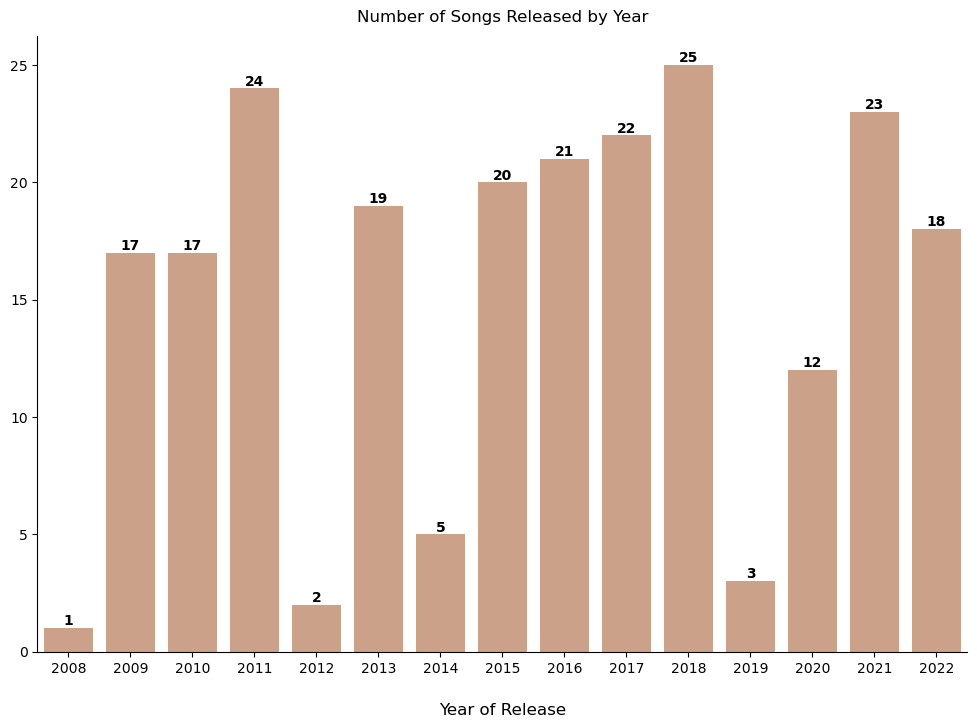

In [355]:
fig = plt.figure(figsize =(12,8))

ax = sns.barplot(
    data = count_year,
    x = 'release_year',
    y = 'count_songs',
    color = '#D69F7E'
)

for dir in ['top', 'right']:
    ax.spines[dir].set_visible(False)

ax.bar_label(ax.containers[0], weight = 'bold')

ax.set_title('Number of Songs Released by Year', pad = 10)
ax.set_ylabel(None)
ax.set_xlabel('Year of Release', labelpad = 20)

plt.show()